## Project summary

__Models__
- Mean model used as a baseline
- Concatenated model
- Dot product model

Further testing done by adding additional 2 continuous data features - average user score and metacritics score

## Setup

In [1]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

In [2]:
from gpu_helper import enable_gpu

enable_gpu()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [3]:
from toai.imports import *
import tensorflow as tf
from tensorflow import keras
from model_utils import show_history
from toai.data.utils import split_df
from toai.metrics import rmse

/home/martynas/ml/.venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
DATA_DIR = Path("data")
TEMP_DIR = Path("temp")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

## EDA and Cleanup

In [5]:
df_game_info = pd.read_csv(DATA_DIR / "metacritic_game_info.csv")
df_game_info.drop(["Unnamed: 0"], axis=1, inplace=True)
df_game_comments = pd.read_csv(DATA_DIR / "metacritic_game_user_comments.csv")
df_game_comments.drop(["Unnamed: 0", "Comment"], axis=1, inplace=True)

In [6]:
df_game_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283983 entries, 0 to 283982
Data columns (total 4 columns):
Title        283983 non-null object
Platform     283983 non-null object
Userscore    283983 non-null int64
Username     283980 non-null object
dtypes: int64(1), object(3)
memory usage: 8.7+ MB


In [7]:
df_game_comments = df_game_comments[
    df_game_comments.groupby("Username")["Username"].transform("size") >= 5
]

In [8]:
df_game_comments = df_game_comments.loc[
    ~df_game_comments["Username"].isin(["AnonymousMC", "[Anonymous]"]), :
].reset_index(drop=True)

In [9]:
df_game_comments["Username"].value_counts()

Broyax            274
iddqd4            255
SuperkenGaming    230
drlowdon          216
TheQuietGamer     211
                 ... 
Xxdaniels751xX      5
Jugalator           5
SuperJosh79         5
draculdracul        5
victorgr            5
Name: Username, Length: 10231, dtype: int64

In [10]:
df_game_comments.head()

,Title,Platform,Userscore,Username
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,doodlerman
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,StevenA
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Nosidda89
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,KendylKlownfish
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Bolts


In [11]:
df_game_info.head()

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
1,Tony Hawk's Pro Skater 2,2000,NeversoftEntertainment,Sports;Alternative;Skateboarding,PlayStation,98,7.4,1-2
2,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,PlayStation3,98,7.5,1 Player
3,SoulCalibur,1999,Namco,Action;Fighting;3D,Dreamcast,98,8.6,1-2
4,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,Xbox360,98,7.9,1 Player


In [12]:
df_game_info["Title"].value_counts()

Madden NFL 07                                      7
Marvel: Ultimate Alliance                          6
This page isn’t working                            6
Tony Hawk's Pro Skater 3                           6
Grand Theft Auto V                                 5
                                                  ..
FTL: Faster Than Light                             1
ECHO                                               1
Kohan: Ahriman's Gift                              1
Tribes: Vengeance                                  1
The 2D Adventures of Rotating Octopus Character    1
Name: Title, Length: 3438, dtype: int64

Same game might have different titles but for different plaforms. We need to uniquely identify the game.

In [13]:
df_game_info[df_game_info["Title"] == "Madden NFL 07"]

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
1880,Madden NFL 07,2006,EASports,Sports;Traditional;Football;Sim,PlayStation2,84,8.2,1-2
2206,Madden NFL 07,2006,EATiburon,Sports;Traditional;Football;Sim,Xbox,83,8.7,1-4
2531,Madden NFL 07,2006,EATiburon,Sports;Traditional;Football;Sim,GameCube,82,7.8,2 Online
3125,Madden NFL 07,2006,EACanada,Sports;Traditional;Team;Football;Sim;Sim,Wii,81,8.0,No Online Multiplayer
3360,Madden NFL 07,2006,EATiburon,Sports;Traditional;Team;Football;Sim;Sim,Xbox360,80,6.0,2 Online
3428,Madden NFL 07,2006,EATiburon,Sports;Traditional;Team;Football;Sim;Sim,PC,80,7.3,2 Online
4388,Madden NFL 07,2006,EATiburon,Sports;Traditional;Team;Football;Sim;Sim,PSP,78,6.6,1-2


In [14]:
def create_game_ids(df):
    """Return dictionary of game titles for specific plaform mapped to unique ID"""

    game_ids = {}
    for idx, key in enumerate(
        np.unique((df["Title"] + " for " + df["Platform"]).values)
    ):
        game_ids[key] = idx

    return game_ids


def apply_game_ids(df, game_ids):
    df["GameID"] = df.apply(
        lambda x: game_ids[(x["Title"] + " for " + x["Platform"])], axis=1
    )

    return df

In [15]:
game_ids = create_game_ids(df_game_info)
df_game_info = apply_game_ids(df_game_info, game_ids)

In [16]:
df_game_info.head()

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players,GameID
0,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player,4209
1,Tony Hawk's Pro Skater 2,2000,NeversoftEntertainment,Sports;Alternative;Skateboarding,PlayStation,98,7.4,1-2,4535
2,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,PlayStation3,98,7.5,1 Player,1612
3,SoulCalibur,1999,Namco,Action;Fighting;3D,Dreamcast,98,8.6,1-2,3725
4,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,Xbox360,98,7.9,1 Player,1613


In [17]:
len(df_game_info), len(np.unique(df_game_info["GameID"]))

(5000, 4993)

In [18]:
df_game_info["GameID"].value_counts()

4391    6
205     3
2047    1
557     1
549     1
       ..
3263    1
1218    1
3267    1
1222    1
0       1
Name: GameID, Length: 4993, dtype: int64

It appears we still have some duplicates

In [19]:
df_game_info[df_game_info["GameID"].isin([4391, 205])]

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players,GameID
1360,Bad Request,not specified,not specified,no genre,not specified,not specified,not specified,not specified,205
2122,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
2123,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
2124,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
2125,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
2126,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
2127,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
4408,Bad Request,not specified,not specified,no genre,not specified,not specified,not specified,not specified,205
4434,Bad Request,not specified,not specified,no genre,not specified,not specified,not specified,not specified,205


In [20]:
df_game_info = df_game_info.loc[
    ~df_game_info["GameID"].isin([4391, 205]), :
].reset_index(drop=True)

In [21]:
len(df_game_info), len(np.unique(df_game_info["GameID"]))

(4991, 4991)

In [22]:
df_game_comments = apply_game_ids(df_game_comments, game_ids)

In [23]:
df_game_comments["UserID"] = df_game_comments.groupby("Username").ngroup()

In [24]:
df_game_comments.head()

,Title,Platform,Userscore,Username,GameID,UserID
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,doodlerman,4209,7976
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,StevenA,4209,6221
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Nosidda89,4209,4864
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,KendylKlownfish,4209,3634
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Bolts,4209,818


In [25]:
df = df_game_comments.drop(["Title", "Platform", "Username"], axis=1)

In [26]:
df = df.merge(df_game_info, left_on="GameID", right_on="GameID")

In [27]:
remove_by_metascore = df[df["Metascore"] == "not specified"]["GameID"].values
df[df["Metascore"] == "not specified"]

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
56092,10,1126,7739,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56093,9,1126,1202,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56094,10,1126,4040,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56095,5,1126,2215,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56096,9,1126,4634,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56097,6,1126,9103,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified


In [28]:
remove_by_avg_score = df[df["Avg_Userscore"].isin(["tbd", "not specified"])][
    "GameID"
].values
df[df["Avg_Userscore"].isin(["tbd", "not specified"])]

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
40432,9,2240,140,Madden NFL 2005,2004,EATiburon,Sports;Traditional;Football;Sim,GameCube,90,tbd,1-4
56092,10,1126,7739,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56093,9,1126,1202,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56094,10,1126,4040,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56095,5,1126,2215,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
...,...,...,...,...,...,...,...,...,...,...,...
100972,9,2571,1609,NASCAR Thunder 2002,2001,EATiburon,Driving;Racing;Stock Car,Xbox,82,tbd,1-4
103258,10,2687,6194,NCAA March Madness 2004,2003,EASports,Sports;Traditional;Basketball;Sim,Xbox,81,tbd,1-4
107600,8,4405,372,Tiger Woods PGA Tour 07,2006,EARedwoodShores,Sports;Traditional;Individual;Golf;Sim;Sim,PlayStation3,81,tbd,Up to 4
110041,8,2127,7151,Lumines Remastered,2018,EnhanceGames,Puzzle;Matching,XboxOne,81,tbd,No Online Multiplayer


In [29]:
df = df.loc[
    ~df["GameID"].isin(np.append(remove_by_metascore, remove_by_avg_score)), :
].reset_index(drop=True)

In [30]:
df["Metascore"] = df["Metascore"].astype("int32")
df["Avg_Userscore"] = df["Avg_Userscore"].astype("float64")

In [31]:
df.describe()

,Userscore,GameID,UserID,Metascore,Avg_Userscore
count,112371.000000,112371.000000,112371.000000,112371.000000,112371.000000
mean,7.911943,2310.923761,5129.801034,87.958931,7.971631
std,2.579331,1481.949997,2969.246196,4.724206,1.092781
min,0.000000,0.000000,0.000000,80.000000,1.600000
25%,7.000000,960.000000,2549.000000,84.000000,7.600000
50%,9.000000,2097.000000,5141.000000,88.000000,8.300000
75%,10.000000,3730.000000,7702.000000,92.000000,8.700000
max,10.000000,4989.000000,10230.000000,99.000000,9.300000


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112371 entries, 0 to 112370
Data columns (total 11 columns):
Userscore        112371 non-null int64
GameID           112371 non-null int64
UserID           112371 non-null int64
Title            112371 non-null object
Year             112371 non-null object
Publisher        112371 non-null object
Genre            112371 non-null object
Platform         112371 non-null object
Metascore        112371 non-null int32
Avg_Userscore    112371 non-null float64
No_Players       112317 non-null object
dtypes: float64(1), int32(1), int64(3), object(6)
memory usage: 9.0+ MB


In [33]:
target_col = "Userscore"

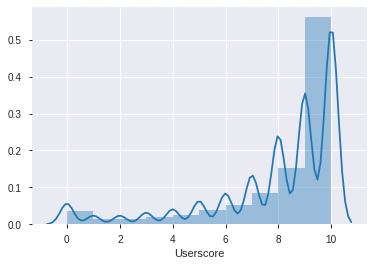

In [34]:
sns.distplot(df[target_col], bins=10)

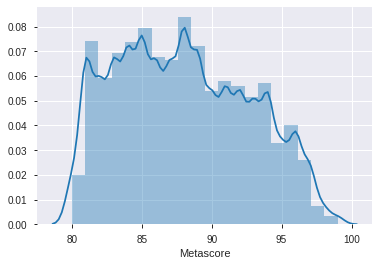

In [35]:
sns.distplot(df["Metascore"], bins=20)

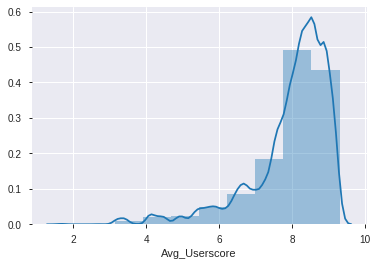

In [36]:
sns.distplot(df["Avg_Userscore"], bins=10)

## Split into train, validation and test datasets

In [37]:
train_df, val_df, test_df = split_df(df, 0.2)

In [38]:
[x.shape for x in (train_df, val_df, test_df)]

[(89896, 11), (11237, 11), (11238, 11)]

## Processing

In [39]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [40]:
scaler.fit(train_df[[target_col]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [41]:
train_df[target_col] = scaler.transform(train_df[[target_col]])

/home/martynas/ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
val_df[target_col] = scaler.transform(val_df[[target_col]])

In [43]:
train_df.head()

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,1.0,1969,7571,Kingdoms of Amalur: Reckoning,2012,BigHugeGames,Role-Playing;PC-style RPG;Action RPG,PlayStation3,81,7.7,No Online Multiplayer
1,0.8,2437,6679,Metroid: Samus Returns,2017,MercurySteam,Action Adventure;Open-World,3DS,85,8.9,No Online Multiplayer
2,0.8,718,4650,DOOM,2016,idSoftware,Sci-Fi;Action;Shooter;First-Person;Third-Perso...,XboxOne,87,8.4,Up to 12
3,1.0,1714,2123,Halo 4,2012,343Industries,Shooter;Sci-Fi;Sci-Fi;Action;Shooter;First-Per...,Xbox360,87,7.0,Up to 16
4,1.0,1379,9287,Final Fantasy VII,1997,SquareSoft,Role-Playing;Console-style RPG,PlayStation,92,9.2,1 Player


In [44]:
train_df[target_col][:10].values

array([1. , 0.8, 0.8, 1. , 1. , 0.5, 1. , 1. , 0.7, 1. ])

In [45]:
scaler.inverse_transform(train_df[[target_col]][:10]).flatten()

array([10.,  8.,  8., 10., 10.,  5., 10., 10.,  7., 10.])

In [46]:
BATCH_SIZE = 512
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [47]:
train_df["UserID"].max(), val_df["UserID"].max(), train_df["GameID"].max(), val_df[
    "GameID"
].max()

(10230, 10230, 4989, 4989)

In [48]:
n_users = 11000
n_games = 5000

In [49]:
train_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (train_df["UserID"].values, train_df["GameID"].values)
            ),
            tf.data.Dataset.from_tensor_slices(train_df[target_col].values),
        )
    )
    .cache()
    .repeat()
    .shuffle(len(train_df))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [50]:
val_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (val_df["UserID"].values, val_df["GameID"].values)
            ),
            tf.data.Dataset.from_tensor_slices(val_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [51]:
class EmbeddingLayer:
    def __init__(self, input_dim: int, embedding_dim: int):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim

    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        layer = keras.layers.Embedding(
            self.input_dim, self.embedding_dim, input_length=(1,)
        )(layer)
        return keras.layers.Flatten()(layer)

In [52]:
def make_concat_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(user_dim, embedding_dim)(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(item_dim, embedding_dim)(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    x = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(x)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [53]:
concat_model = make_concat_model(
    n_users, n_games, 128, layer_size=512, dropout_rate=0.3, regularization=(1e-8, 1e-4)
)

In [54]:
concat_model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [55]:
PATIENCE = 5

train_data_steps = len(train_df) // BATCH_SIZE
concat_model_history = concat_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

In [102]:
pd.DataFrame(concat_model_history.history).tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,lr
95,0.061021,0.130053,0.077430,0.154214,0.00003
96,0.060507,0.130080,0.077101,0.154084,0.00003
97,0.060382,0.130270,0.076631,0.154096,0.00003
98,0.059071,0.128749,0.076066,0.153966,0.00003
99,0.058970,0.129494,0.075852,0.154161,0.00003


(None, None)

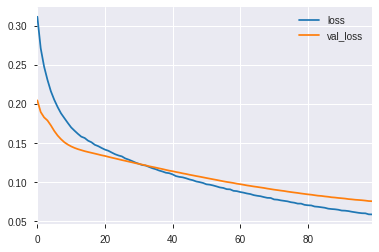

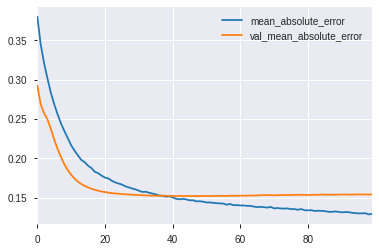

In [56]:
show_history(concat_model_history, "loss"), show_history(concat_model_history, "err")

In [57]:
def make_dot_model(user_dim, item_dim, embedding_dim):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(user_dim, embedding_dim)(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(item_dim, embedding_dim)(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias])
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [58]:
dot_model = make_dot_model(n_users, n_games, 128)

In [59]:
dot_model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [60]:
PATIENCE = 5

train_data_steps = len(train_df) // BATCH_SIZE
dot_model_history = dot_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

In [103]:
pd.DataFrame(dot_model_history.history).tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,lr
95,0.070693,0.236284,0.095405,0.277220,0.00003
96,0.069802,0.234423,0.094743,0.275990,0.00003
97,0.068699,0.232417,0.094088,0.274762,0.00003
98,0.067962,0.230937,0.093429,0.273521,0.00003
99,0.067326,0.229460,0.092781,0.272290,0.00003


(None, None)

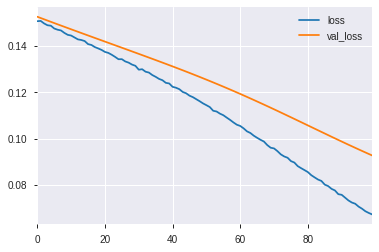

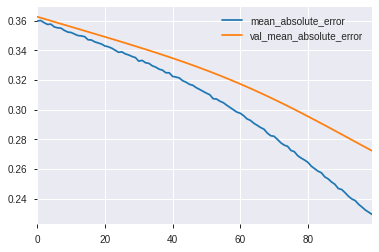

In [61]:
show_history(dot_model_history, "loss"), show_history(dot_model_history, "err")

In [62]:
class MeanModel(keras.Model):
    def __init__(self, mean):
        super().__init__()
        self.mean = tf.constant(mean, dtype=tf.float32)

    def call(self, inputs):
        return tf.ones_like(inputs[0], dtype=tf.float32) * self.mean

In [63]:
mean_model = MeanModel(train_df[target_col].mean())

In [64]:
mean_model.compile(optimizer=keras.optimizers.Adam(3e-4), loss=keras.losses.mse)

In [65]:
mean_model.predict(val_dataset)

array([[0.79109526],
       [0.79109526],
       [0.79109526],
       ...,
       [0.79109526],
       [0.79109526],
       [0.79109526]], dtype=float32)

## Model evaluation

In [66]:
def evaluate_predictions(model, dataset, scaler, metric):
    y_true = np.concatenate(
        [scaler.inverse_transform(y.numpy().reshape(-1, 1)) for _, y in dataset]
    )
    y_pred = scaler.inverse_transform(model.predict(dataset))

    return metric(y_true, y_pred)

In [67]:
for model in [concat_model, dot_model, mean_model]:
    print(evaluate_predictions(model, val_dataset, scaler, rmse))

2.252371785482778
3.045896526270643
2.580083232823595


### Evaluate with test dataset

In [68]:
test_df[target_col] = scaler.transform(test_df[[target_col]])

In [69]:
test_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (test_df["UserID"].values, test_df["GameID"].values)
            ),
            tf.data.Dataset.from_tensor_slices(test_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [70]:
for model in [concat_model, dot_model, mean_model]:
    print(evaluate_predictions(model, test_dataset, scaler, rmse))

2.2709044566238186
3.024118667684487
2.594963121637558


## Modeling with additional features

Now including 2 additional continuous data features - "Metascore" and "Avg_Userscore"

In [71]:
feature_train_df, feature_val_df, feature_test_df = split_df(df, 0.2)

In [72]:
feature_cols = ["Metascore", "Avg_Userscore"]

In [73]:
feature_label_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler = MinMaxScaler(feature_range=(0, 1))

In [74]:
feature_label_scaler.fit(feature_train_df[[target_col]])
feature_scaler.fit(feature_train_df[feature_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [75]:
feature_train_df[target_col] = feature_label_scaler.transform(
    feature_train_df[[target_col]]
)
feature_val_df[target_col] = feature_label_scaler.transform(
    feature_val_df[[target_col]]
)

/home/martynas/ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [76]:
feature_train_df[feature_cols] = feature_scaler.transform(
    feature_train_df[feature_cols]
)
feature_val_df[feature_cols] = feature_scaler.transform(feature_val_df[feature_cols])

/home/martynas/ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/martynas/ml/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [77]:
feature_train_df.head()

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,1.0,1969,7571,Kingdoms of Amalur: Reckoning,2012,BigHugeGames,Role-Playing;PC-style RPG;Action RPG,PlayStation3,0.052632,0.792208,No Online Multiplayer
1,0.8,2437,6679,Metroid: Samus Returns,2017,MercurySteam,Action Adventure;Open-World,3DS,0.263158,0.948052,No Online Multiplayer
2,0.8,718,4650,DOOM,2016,idSoftware,Sci-Fi;Action;Shooter;First-Person;Third-Perso...,XboxOne,0.368421,0.883117,Up to 12
3,1.0,1714,2123,Halo 4,2012,343Industries,Shooter;Sci-Fi;Sci-Fi;Action;Shooter;First-Per...,Xbox360,0.368421,0.701299,Up to 16
4,1.0,1379,9287,Final Fantasy VII,1997,SquareSoft,Role-Playing;Console-style RPG,PlayStation,0.631579,0.987013,1 Player


In [78]:
train_feature_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                tuple(
                    [
                        feature_train_df["UserID"].values,
                        feature_train_df["GameID"].values,
                    ]
                    + [feature_train_df[feature_cols].values]
                )
            ),
            tf.data.Dataset.from_tensor_slices(feature_train_df[target_col].values),
        )
    )
    .cache()
    .repeat()
    .shuffle(len(feature_train_df))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [79]:
val_feature_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                tuple(
                    [feature_val_df["UserID"].values, feature_val_df["GameID"].values]
                    + [feature_val_df[feature_cols].values]
                )
            ),
            tf.data.Dataset.from_tensor_slices(feature_val_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [80]:
def make_feature_concat_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(user_dim, embedding_dim)(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(item_dim, embedding_dim)(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    feature_input = keras.layers.Input(shape=(2,))
    features = keras.backend.sum(feature_input, axis=1, keepdims=True)

    x = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias, features]
    )
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(x)

    model = keras.Model(inputs=[user_input, item_input, feature_input], outputs=outputs)
    return model

In [81]:
feature_concat_model = make_feature_concat_model(
    n_users, n_games, 128, layer_size=512, dropout_rate=0.3, regularization=(1e-8, 1e-4)
)

In [82]:
feature_concat_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 128)       1408000     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 1)         11000       input_5[0][0]                    
____________________________________________________________________________________________

In [83]:
feature_concat_model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [84]:
PATIENCE = 5

train_data_steps = len(feature_train_df) // BATCH_SIZE
concat_feature_model_history = feature_concat_model.fit(
    train_feature_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_feature_dataset,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

In [104]:
pd.DataFrame(concat_feature_model_history.history).tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,lr
95,0.061193,0.130365,0.077693,0.155766,0.00003
96,0.060561,0.130274,0.077348,0.155895,0.00003
97,0.059549,0.128948,0.076986,0.155944,0.00003
98,0.059426,0.129497,0.076466,0.155690,0.00003
99,0.058345,0.128093,0.076181,0.155767,0.00003


(None, None)

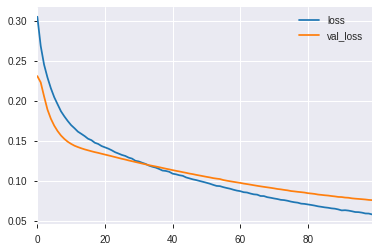

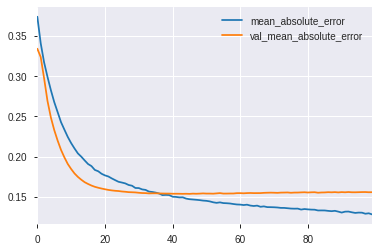

In [85]:
show_history(concat_feature_model_history, "loss"), show_history(
    concat_feature_model_history, "err"
)

In [86]:
def make_feature_dot_model(user_dim, item_dim, embedding_dim):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1)(
        user_input
    )
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1)(
        item_input
    )
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    feature_input = keras.layers.Input(shape=(2,))
    features = keras.backend.sum(feature_input, axis=1, keepdims=True)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias, features])
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(inputs=[user_input, item_input, feature_input], outputs=outputs)
    return model

In [87]:
feature_dot_model = make_feature_dot_model(n_users, n_games, 128)

In [88]:
feature_dot_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 128)       1408000     input_8[0][0]                    
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 128)       640000      input_9[0][0]                    
____________________________________________________________________________________________

In [89]:
feature_dot_model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [90]:
PATIENCE = 5

train_data_steps = len(feature_train_df) // BATCH_SIZE
feature_dot_model_history = feature_dot_model.fit(
    train_feature_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_feature_dataset,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

In [105]:
pd.DataFrame(feature_dot_model_history.history).tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,lr
95,0.042713,0.153512,0.056142,0.179157,0.00003
96,0.042264,0.152853,0.056097,0.179064,0.00003
97,0.042196,0.152520,0.056052,0.178973,0.00003
98,0.042055,0.152015,0.056008,0.178885,0.00003
99,0.041716,0.151427,0.055962,0.178791,0.00003


(None, None)

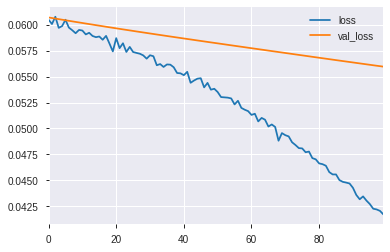

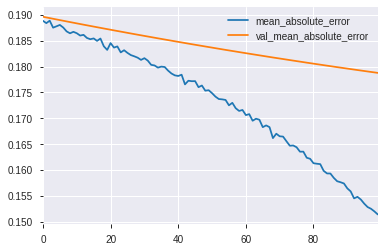

In [91]:
show_history(feature_dot_model_history, "loss"), show_history(
    feature_dot_model_history, "err"
)

In [92]:
def evaluate_feature_predictions(model, dataset, scaler, metric):
    y_true = np.concatenate(
        [scaler.inverse_transform(y.numpy().reshape(-1, 1)) for _, y in dataset]
    )
    y_pred = scaler.inverse_transform(model.predict(dataset))

    return metric(y_true, y_pred)

In [93]:
for model in [feature_concat_model, feature_dot_model]:
    print(
        evaluate_feature_predictions(
            model, val_feature_dataset, feature_label_scaler, rmse
        )
    )

2.2596232531587077
2.3659924360560733


For comparison with previous iteration:  
__Concat Model__: 2.252 >> 2.259   
__Dot Model__: 3.06 >> 2.366

### Evaluate with test dataset

In [94]:
feature_test_df[target_col] = feature_label_scaler.transform(
    feature_test_df[[target_col]]
)
feature_test_df[feature_cols] = feature_scaler.transform(feature_test_df[feature_cols])

In [95]:
test_feature_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                tuple(
                    [feature_test_df["UserID"].values, feature_test_df["GameID"].values]
                    + [feature_test_df[feature_cols].values]
                )
            ),
            tf.data.Dataset.from_tensor_slices(feature_test_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [96]:
for model in [feature_concat_model, feature_dot_model]:
    print(
        evaluate_feature_predictions(
            model, test_feature_dataset, feature_label_scaler, rmse
        )
    )

2.273660130964289
2.3806387575853356


For comparison with previous iteration:  
__Concat Model__: 2.279 >> 2.271  
__Dot Model__: 3.05 >> 2.38

## Modeling with additional features and additional embedding

In [97]:
df.head()

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,10,4209,7976,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
1,10,4209,6221,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
2,10,4209,4864,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
3,10,4209,3634,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
4,10,4209,818,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player


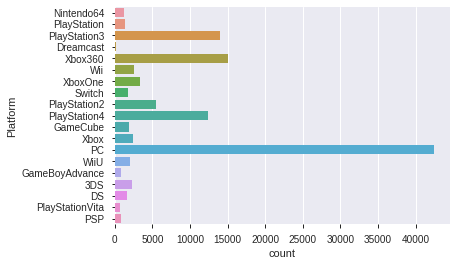

In [98]:
sns.countplot(y="Platform", data=df)

In [99]:
platform_map = {
    platform: idx for idx, platform in enumerate(np.unique(df["Platform"].values))
}

In [100]:
platform_map

{'3DS': 0,
 'DS': 1,
 'Dreamcast': 2,
 'GameBoyAdvance': 3,
 'GameCube': 4,
 'Nintendo64': 5,
 'PC': 6,
 'PSP': 7,
 'PlayStation': 8,
 'PlayStation2': 9,
 'PlayStation3': 10,
 'PlayStation4': 11,
 'PlayStationVita': 12,
 'Switch': 13,
 'Wii': 14,
 'WiiU': 15,
 'Xbox': 16,
 'Xbox360': 17,
 'XboxOne': 18}

In [101]:
df["PlatfromID"] = df.apply(lambda x: platform_map[x["Platform"]], axis=1)

In [55]:
df.head()

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players,PlatfromID
0,10,4209,7976,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player,5
1,10,4209,6221,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player,5
2,10,4209,4864,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player,5
3,10,4209,3634,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player,5
4,10,4209,818,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player,5


In [106]:
feature_train_df2, feature_val_df2, feature_test_df2 = split_df(df, 0.2)

In [57]:
feature_cols = ["Metascore", "Avg_Userscore"]

In [58]:
feature_label_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler = MinMaxScaler(feature_range=(0, 1))

In [107]:
feature_label_scaler.fit(feature_train_df2[[target_col]])
feature_scaler.fit(feature_train_df2[feature_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [108]:
feature_train_df2[feature_cols] = feature_scaler.transform(
    feature_train_df2[feature_cols]
)
feature_val_df2[feature_cols] = feature_scaler.transform(feature_val_df2[feature_cols])

/home/martynas/ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/martynas/ml/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [109]:
feature_train_df2[target_col] = feature_label_scaler.transform(
    feature_train_df2[[target_col]]
)
feature_val_df2[target_col] = feature_label_scaler.transform(
    feature_val_df2[[target_col]]
)

/home/martynas/ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
feature_train_df2.head()

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players,PlatfromID
0,1.0,1969,7571,Kingdoms of Amalur: Reckoning,2012,BigHugeGames,Role-Playing;PC-style RPG;Action RPG,PlayStation3,0.052632,0.792208,No Online Multiplayer,10
1,0.8,2437,6679,Metroid: Samus Returns,2017,MercurySteam,Action Adventure;Open-World,3DS,0.263158,0.948052,No Online Multiplayer,0
2,0.8,718,4650,DOOM,2016,idSoftware,Sci-Fi;Action;Shooter;First-Person;Third-Perso...,XboxOne,0.368421,0.883117,Up to 12,18
3,1.0,1714,2123,Halo 4,2012,343Industries,Shooter;Sci-Fi;Sci-Fi;Action;Shooter;First-Per...,Xbox360,0.368421,0.701299,Up to 16,17
4,1.0,1379,9287,Final Fantasy VII,1997,SquareSoft,Role-Playing;Console-style RPG,PlayStation,0.631579,0.987013,1 Player,8


In [111]:
train_feature_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                tuple(
                    [
                        feature_train_df2["UserID"].values,
                        feature_train_df2["GameID"].values,
                    ]
                    + [feature_train_df2[feature_cols].values]
                    + [feature_train_df2["PlatfromID"].values]
                )
            ),
            tf.data.Dataset.from_tensor_slices(feature_train_df2[target_col].values),
        )
    )
    .cache()
    .repeat()
    .shuffle(len(feature_train_df2))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [113]:
val_feature_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                tuple(
                    [feature_val_df2["UserID"].values, feature_val_df2["GameID"].values]
                    + [feature_val_df2[feature_cols].values]
                    + [feature_val_df2["PlatfromID"].values]
                )
            ),
            tf.data.Dataset.from_tensor_slices(feature_val_df2[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [114]:
def make_feature_concat_model(
    user_dim,
    item_dim,
    platform_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(user_dim, embedding_dim)(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(item_dim, embedding_dim)(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    feature_input = keras.layers.Input(shape=(2,))
    features = keras.backend.sum(feature_input, axis=1, keepdims=True)

    platform_input = keras.layers.Input(shape=(1,))
    platform_embedding = EmbeddingLayer(platform_dim, embedding_dim)(platform_input)
    platform_bias = EmbeddingLayer(platform_dim, 1)(platform_input)

    x = keras.layers.Concatenate()(
        [
            user_embedding,
            user_bias,
            item_embedding,
            item_bias,
            features,
            platform_embedding,
            platform_bias,
        ]
    )
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(x)

    model = keras.Model(
        inputs=[user_input, item_input, feature_input, platform_input], outputs=outputs
    )
    return model

In [115]:
n_platforms = 20

In [116]:
feature_concat_model = make_feature_concat_model(
    n_users,
    n_games,
    n_platforms,
    128,
    layer_size=512,
    dropout_rate=0.3,
    regularization=(1e-8, 1e-4),
)

In [117]:
feature_concat_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 1, 128)       1408000     input_11[0][0]                   
____________________________________________________________________________________________

In [118]:
feature_concat_model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [119]:
PATIENCE = 5

train_data_steps = len(feature_train_df) // BATCH_SIZE
concat_feature_model_history2 = feature_concat_model.fit(
    train_feature_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_feature_dataset,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

(None, None)

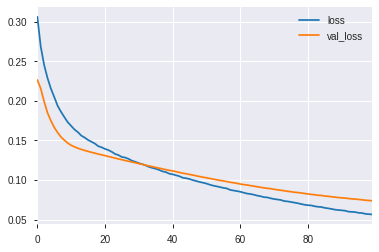

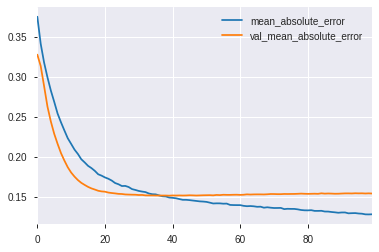

In [136]:
show_history(concat_feature_model_history2, "loss"), show_history(
    concat_feature_model_history2, "err"
)

In [137]:
pd.DataFrame(concat_feature_model_history2.history).tail()

,loss,mean_absolute_error,val_loss,val_mean_absolute_error,lr
95,0.058806,0.129548,0.075670,0.154683,0.00003
96,0.058502,0.129294,0.075229,0.154751,0.00003
97,0.057512,0.128485,0.074675,0.154525,0.00003
98,0.057066,0.128403,0.074367,0.154701,0.00003
99,0.056785,0.128557,0.073981,0.154477,0.00003


In [129]:
def make_feature_dot_model(user_dim, item_dim, platform_dim, embedding_dim):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(user_dim, embedding_dim)(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(item_dim, embedding_dim)(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    feature_input = keras.layers.Input(shape=(2,))
    features = keras.backend.sum(feature_input, axis=1, keepdims=True)

    platform_input = keras.layers.Input(shape=(1,))
    platform_embedding = EmbeddingLayer(platform_dim, embedding_dim)(platform_input)
    platform_bias = EmbeddingLayer(platform_dim, 1)(platform_input)

    p = keras.layers.Add()([item_embedding, platform_embedding])

    dot_product = keras.layers.Dot(axes=1)([user_embedding, p])
    logits = keras.layers.Add()(
        [dot_product, user_bias, item_bias, features, platform_bias]
    )
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(
        inputs=[user_input, item_input, feature_input, platform_input], outputs=outputs
    )
    return model

In [130]:
feature_dot_model = make_feature_dot_model(n_users, n_games, n_platforms, 128)

In [131]:
feature_dot_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_36 (Embedding)        (None, 1, 128)       640000      input_24[0][0]                   
____________________________________________________________________________________________

In [132]:
feature_dot_model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [134]:
PATIENCE = 5

train_data_steps = len(feature_train_df) // BATCH_SIZE
feature_dot_model_history = feature_dot_model.fit(
    train_feature_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_feature_dataset,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

(None, None)

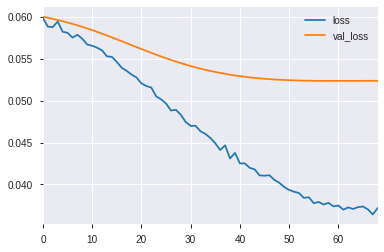

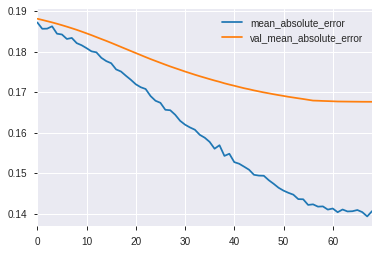

In [135]:
show_history(feature_dot_model_history, "loss"), show_history(
    feature_dot_model_history, "err"
)

In [138]:
for model in [feature_concat_model, feature_dot_model]:
    print(
        evaluate_feature_predictions(
            model, val_feature_dataset, feature_label_scaler, rmse
        )
    )

2.250295864127757
2.2888768944494116


## Evaluate with test dataset

In [139]:
feature_test_df2[target_col] = feature_label_scaler.transform(
    feature_test_df2[[target_col]]
)
feature_test_df2[feature_cols] = feature_scaler.transform(
    feature_test_df2[feature_cols]
)

In [140]:
test_feature_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                tuple(
                    [
                        feature_test_df2["UserID"].values,
                        feature_test_df2["GameID"].values,
                    ]
                    + [feature_test_df2[feature_cols].values]
                    + [feature_test_df2["PlatfromID"].values]
                )
            ),
            tf.data.Dataset.from_tensor_slices(feature_test_df2[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [141]:
for model in [feature_concat_model, feature_dot_model]:
    print(
        evaluate_feature_predictions(
            model, test_feature_dataset, feature_label_scaler, rmse
        )
    )

2.266921892819914
2.296786786102784


## Summary

Results from evaluation on test dataset

| Model  | Stage I | Stage II | Stage III |
|--------|---------|----------|-----------|
| Concat | 2.271   | 2.274    | 2.267     |
| Dot    | 3.024   | 2.381    | 2.297     |